In [31]:
import os
import csv
import numpy as np
import pandas as pd
from itertools import chain
from scipy.stats import linregress,gaussian_kde
import corner

import thesis_tools

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]

% matplotlib inline

plt.style.use('sm')

In [52]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()

sl_data=thesis_tools.load_data(primary_sightlines)
all_data=thesis_tools.load_results(sl_data)

sheffer_data=pd.read_csv('sheffer_co_h2.csv')

In [6]:
# Compiles the Jenkins f1,f2 data
jenkins_c_data=pd.read_csv('jenkins_c_table.txt',header=23)
jenkins_c_data['C*']=np.log10(jenkins_c_data['f1']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C**']=np.log10(jenkins_c_data['f2']*jenkins_c_data['N(CIt)'])
jenkins_c_data['C']=np.log10(jenkins_c_data['N(CIt)']-(jenkins_c_data['C*']+jenkins_c_data['C**']))
jenkins_c_data=jenkins_c_data.rename(index=str, columns={"N(CIt)": "Ctot", "Name": "Sightline", "Vel":"Velocity"})
jenkins_c_data=jenkins_c_data[['Sightline','Velocity','C','C*','C**','Ctot','f1','e_f1','f2','e_f2']]

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


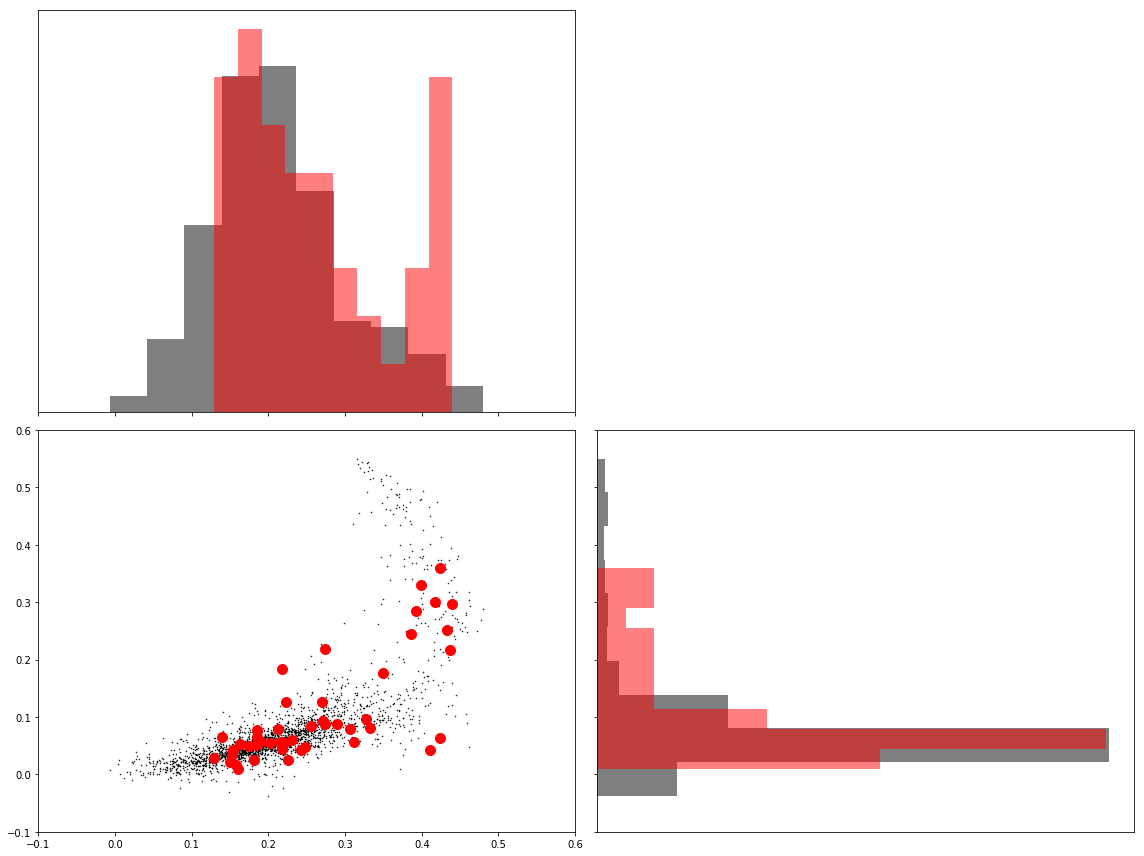

In [13]:
gs=gridspec.GridSpec(2,2)
fig=plt.figure(1,figsize=(16,12))
subplt1=plt.subplot(gs[0])
subplt2=plt.subplot(gs[2])
subplt3=plt.subplot(gs[3])
subplts=[subplt1,subplt2,subplt3]
norm=Normalize(vmin=12,vmax=17)
x = jenkins_c_data['f1']
y = jenkins_c_data['f2']
xmin, xmax = -0.1, 0.6
ymin, ymax = -0.1, 0.6

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

#subplt2.contour(xx, yy, f, 100,cmap='viridis',alpha=0.2,zorder=1)
subplt2.plot(x,y,'ko',markersize=0.5,zorder=1)
subplt2.set_xlim(xmin,xmax)
subplt2.set_ylim(ymin,ymax)

f1s=[]
f2s=[]

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)]
#for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
#    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    
for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    f1=(10**row['C*'])/Ctot
    f2=(10**row['C**'])/Ctot
    f1s.append(f1)
    f2s.append(f2)
    sc=subplt2.scatter(f1,f2,
                   c='r',vmin=11,vmax=16.5,cmap='viridis',marker='o',s=100,zorder=2)
    #subplt2.text((10**row['C*'])/Ctot,(10**row['C**'])/Ctot,row['Sightline'])
    
#inset1=inset_axes(subplt2,width='3%',height='75%',loc=2)
#plt.colorbar(sc,cax=inset1)
    
subplt1.hist(x,bins=10,normed=True,alpha=0.5,color='k')
subplt1.hist(f1s,bins=10,normed=True,alpha=0.5,color='r')
subplt1.set_xlim(xmin,xmax)
subplt1.tick_params(labelbottom='off')
subplt1.get_yaxis().set_visible(False)

subplt3.hist(y,bins=10,normed=True,alpha=0.5,orientation='horizontal',color='k')
subplt3.hist(f2s,bins=10,normed=True,alpha=0.5,orientation='horizontal',color='r')
subplt3.set_ylim(ymin,ymax)
subplt3.tick_params(labelleft='off')
subplt3.get_xaxis().set_visible(False)
plt.tight_layout()
#plt.colorbar(sc)

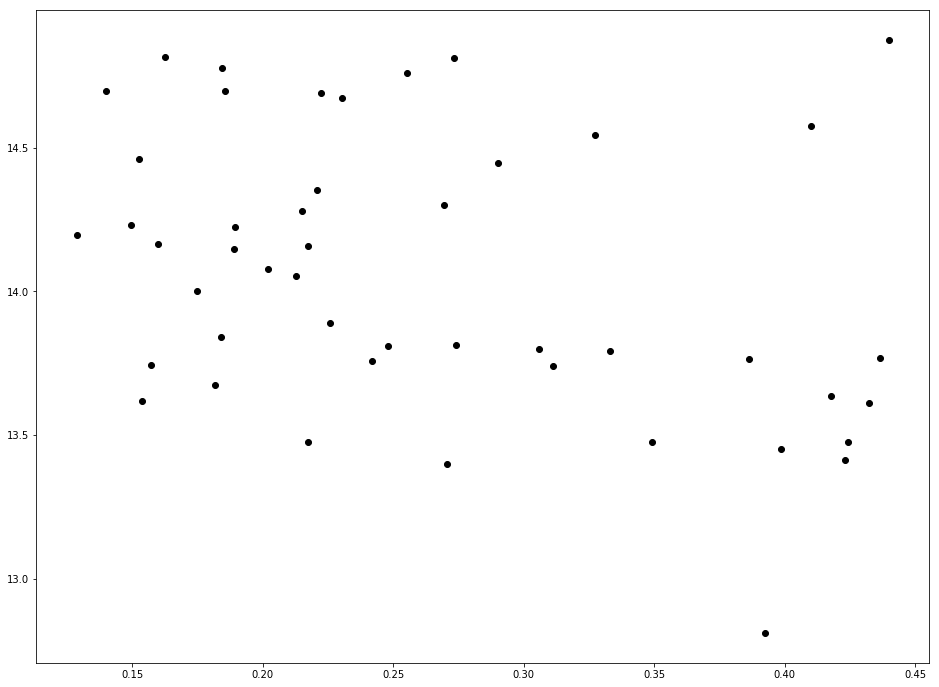

In [9]:
cut_data=cut_data.assign(sortval = (10.**cut_data['C*'])/(10.**cut_data['C']+10.**cut_data['C*']+10.**cut_data['C**'])).sort_values('sortval').drop('sortval', 1)
#for idx,row in cut_data.iterrows():
#    print '{:>9}'.format(row['Sightline']),round(row['C'],3),round(row['C_err'],3),round((10.**row['C*'])/(10.**row['C']+10.**row['C*']+10.**row['C**']),4)
    
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
subplt.plot((10.**cut_data['C*'])/(10.**cut_data['C']+10.**cut_data['C*']+10.**cut_data['C**']),
            cut_data['C'],'ko')

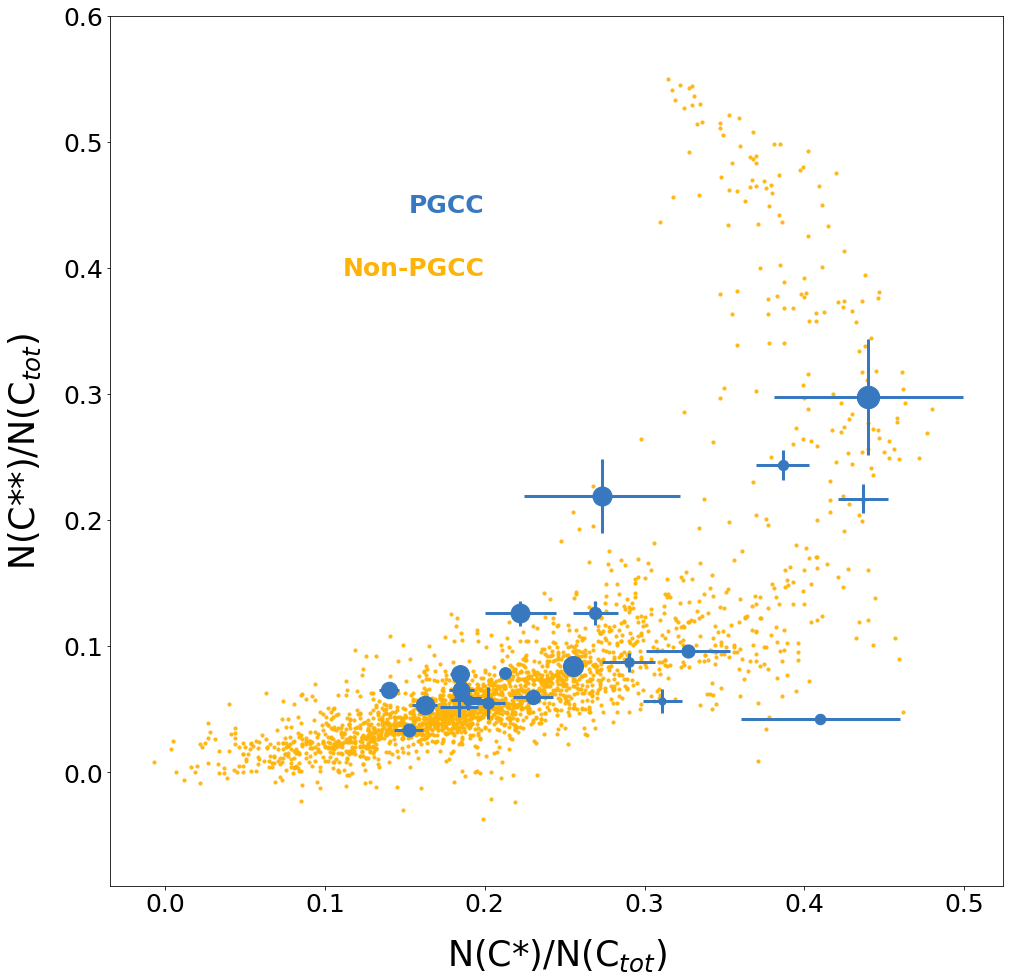

In [21]:
fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)

xmin, xmax = -0.1, 0.53
ymin, ymax = -0.1, 0.6
#subplt.set_xlim(0.2*xmin,xmax)
subplt.set_ylim(0.9*ymin,ymax)

x = jenkins_c_data['f1']
y = jenkins_c_data['f2']
subplt.scatter(x,y,marker='o',color=amber,alpha=0.9,s=10,zorder=1)

f1s=[]
f2s=[]

cut_data=all_data[(all_data['C']>0)&(all_data['C*']>0)&(all_data['C**']>0)]
for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    
#for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    del_Ctot=np.sqrt(np.sum([10**(row[c+'_err']) for c in ('C','C*','C**')]))
    f1=(10**row['C*'])/Ctot
    del_f1=f1*np.sqrt((10**(row['C*_err']-row['C*']))**2+(del_Ctot/Ctot)**2)
    f2=(10**row['C**'])/Ctot
    del_f2=f2*np.sqrt((10**(row['C**_err']-row['C**']))**2+(del_Ctot/Ctot)**2)
    f1s.append(f1)
    f2s.append(f2)
    subplt.errorbar(f1,f2,xerr=del_f1,yerr=del_f2,marker='o',color=blue,ms=(row['CO']-12)*5,zorder=2,elinewidth=3)
    
    # Plots other CO rows along sightlines
    if len(sl[1].sort_values('CO',ascending=False)) > 1:
        extra_rows=sl[1].sort_values('CO',ascending=False).iloc[1:]
        for idx,row in extra_rows.iterrows():
            Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
            f1=(10**row['C*'])/Ctot
            f2=(10**row['C**'])/Ctot
            f1s.append(f1)
            f2s.append(f2)
            #sc=subplt.scatter(f1,f2,
            #       c=blue,vmin=11,vmax=16.5,cmap='viridis',marker='o',s=200,zorder=1)
        
# 
for idx,row in cut_data.iterrows():
    Ctot=10.**row['C']+10.**row['C*']+10.**row['C**']
    f1=(10**row['C*'])/Ctot
    f2=(10**row['C**'])/Ctot
    f1s.append(f1)
    f2s.append(f2)
    if row['CO']>0:
        color=blue
    else:
        color='r'
    #sc=subplt.scatter(f1,f2,
    #            c=color,vmin=11,vmax=16.5,cmap='viridis',marker='o',s=200,zorder=2)
    
    
subplt.tick_params(axis='both', which='major', labelsize=25)
subplt.set_ylabel('N(C**)/N(C$_{tot}$)',fontsize=35,labelpad=20)
subplt.set_xlabel('N(C*)/N(C$_{tot}$)',fontsize=35,labelpad=20)

subplt.text(0.2,0.45,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
subplt.text(0.2,0.4,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)

plt.savefig('/Users/codydirks/Dropbox/Thesis/Thesis/figures/carbon_pressures.png')

Text(0.98,0.02,u'\\textbf{Non-PGCC}')

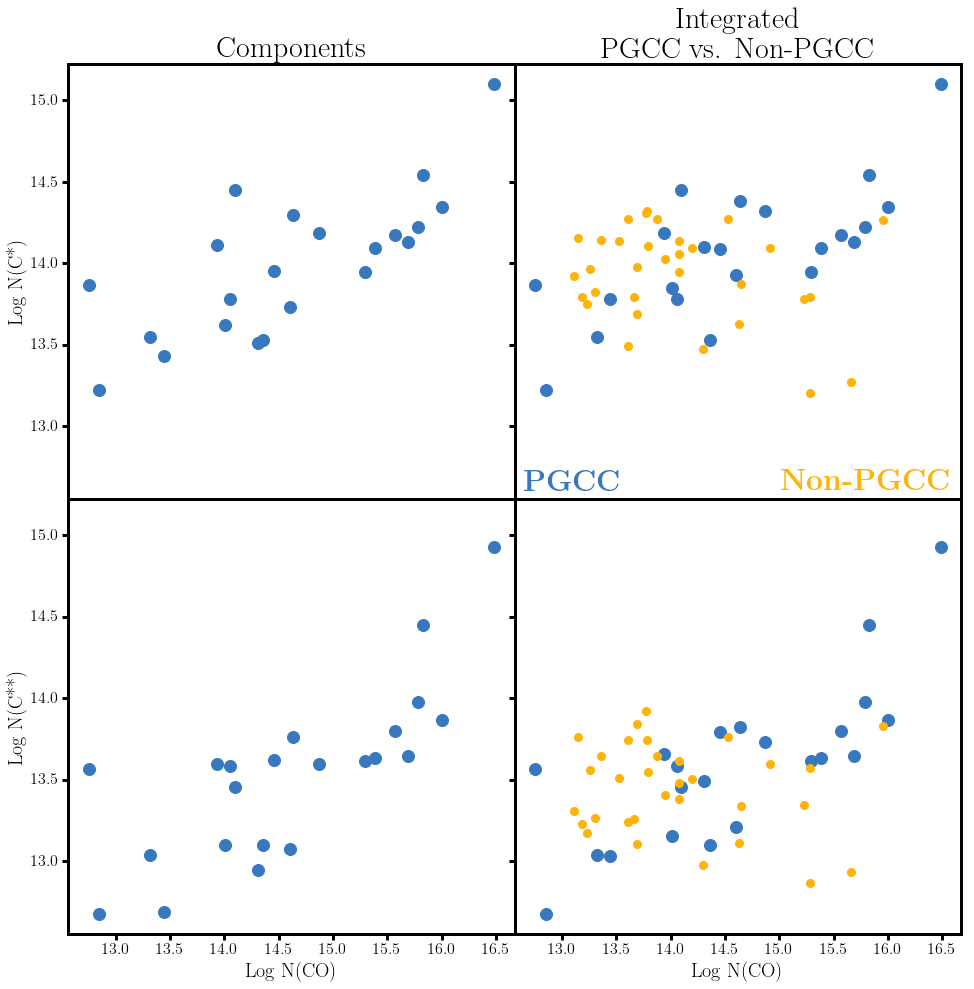

In [73]:
fig,((subplt1,subplt2),(subplt3,subplt4)) = plt.subplots(nrows=2,ncols=2, sharex=True,sharey=True,figsize=(16,16))
plt.subplots_adjust(hspace=0,wspace=0)

cut_data=all_data[(all_data['CO']>0) & (all_data['C*']>0)]
for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    subplt1.plot(row['CO'],row['C*'],marker='o',color=blue,markersize=12)
    subplt2.plot(row['CO'],np.log10(np.sum(10**sl[1]['C*'])),marker='o',color=blue,markersize=12)
    
subplt1.set_ylabel('Log N(C*)')
#subplt1.set_ylim(12.7,15.5)

cut_data=all_data[(all_data['CO']>0) & (all_data['C**']>0)]
for sl in cut_data.groupby('Sightline'):
    #Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    subplt3.plot(row['CO'],row['C**'],marker='o',color=blue,markersize=12)
    subplt4.plot(row['CO'],np.log10(np.sum(10**sl[1]['C**'])),marker='o',color=blue,markersize=12)
    
for sl in list(set(sheffer_data['#Sightline'].unique()).intersection(set(jenkins_c_data['Sightline']))):
    sheffer=sheffer_data[sheffer_data['#Sightline']==sl]
    jenkins=jenkins_c_data[jenkins_c_data['Sightline']==sl]
    c1sum=np.log10(np.sum(10**jenkins['C*']))
    c2sum=np.log10(np.sum(10**jenkins['C**']))
    subplt2.plot(sheffer['CO'],c1sum,marker='o',color=amber,markersize=8)
    subplt4.plot(sheffer['CO'],c2sum,marker='o',color=amber,markersize=8)
    
subplt3.set_ylabel('Log N(C**)')
subplt3.set_xlabel('Log N(CO)')
subplt4.set_xlabel('Log N(CO)')
#subplt3.set_ylim(12,15.3)
subplt1.set_title('Components',fontsize=30)
subplt2.set_title('Integrated\nPGCC vs. Non-PGCC',fontsize=30)

subplt2.text(0.02,0.02,'\\textbf{PGCC}',color=blue,fontsize=30,ha='left',transform=subplt2.transAxes)
subplt2.text(0.98,0.02,'\\textbf{Non-PGCC}',color=amber,fontsize=30,ha='right',transform=subplt2.transAxes)